<a href="https://colab.research.google.com/github/leokan92/class/blob/main/Aula_3_Redes_neurais_recorrentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 3 - Redes neurais recorrentes

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Dataset com dados sintéticos



In [35]:
# Gerar dados mais complexos
def generate_complex_data(sequence_length, num_samples, noise=0.1):
    x_values = np.linspace(0, 8 * np.pi, sequence_length)  # Aumentando o período
    data = np.array([np.sin(x_values) + 0.5 * np.sin(2 * x_values + np.pi / 4) for _ in range(num_samples)])
    data = data + noise * np.random.randn(num_samples, sequence_length)
    data = data.reshape((num_samples, sequence_length, 1))
    return torch.tensor(data, dtype=torch.float32)


In [36]:
# Gerar dados com dependências de longo alcance
def generate_complex_data_with_noise(sequence_length, num_samples, noise=0.1):
    intervals = np.linspace(0, 50 * np.pi, sequence_length)
    data = np.sin(intervals) * np.sin(0.1 * intervals)
    data = np.array([data for _ in range(num_samples)])
    data = data + noise * np.random.randn(num_samples, sequence_length)
    return torch.tensor(data, dtype=torch.float32).view(num_samples, sequence_length, -1)


In [37]:
# Parâmetros
sequence_length = 400  # Aumentando o tamanho da sequência
num_train_samples = 1000
num_test_samples = 200

train_data = generate_complex_data_with_noise(sequence_length, num_train_samples)
test_data = generate_complex_data_with_noise(sequence_length, num_test_samples)

## Definimos os modelos

In [38]:
# Definir modelos
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.linear(output)
        return output

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.linear(output)
        return output

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        output, _ = self.gru(x)
        output = self.linear(output)
        return output

## Definimos os otimizadores, etc.

In [39]:
# Parâmetros
input_dim = 1
hidden_dim = 32
learning_rate = 0.01
num_epochs = 100

# Instanciar modelos e otimizadores
rnn_model = RNNModel(input_dim, hidden_dim)
lstm_model = LSTMModel(input_dim, hidden_dim)
gru_model = GRUModel(input_dim, hidden_dim)

optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=learning_rate)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=learning_rate)
optimizer_gru = optim.Adam(gru_model.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

## Treino

In [40]:
import time

# Treinamento
def train_model(model, optimizer):
    loss_history = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_data)
        loss = criterion(output[:, :-1, :], train_data[:, 1:, :])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    return loss_history

# Função para treinar e cronometrar o modelo
def train_and_time_model(model, optimizer):
    start_time = time.time()
    loss_curve = train_model(model, optimizer)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return loss_curve, elapsed_time

## Teste e comparação

RNN Test Loss: 0.04998217150568962, Time: 39.76 seconds
LSTM Test Loss: 0.04977691173553467, Time: 139.75 seconds
GRU Test Loss: 0.04849305748939514, Time: 113.86 seconds


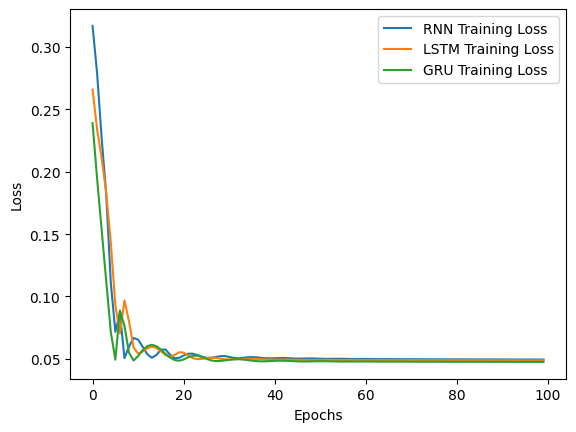

In [41]:
# Avaliar modelos em conjunto de testes
def evaluate_model(model, test_data):
    model.eval()
    with torch.no_grad():
        output = model(test_data)
        loss = criterion(output[:, :-1, :], test_data[:, 1:, :])
    return loss.item()

# Treinamento e cronometragem
rnn_loss, rnn_time = train_and_time_model(rnn_model, optimizer_rnn)
lstm_loss, lstm_time = train_and_time_model(lstm_model, optimizer_lstm)
gru_loss, gru_time = train_and_time_model(gru_model, optimizer_gru)


# Avaliação
rnn_test_loss = evaluate_model(rnn_model, test_data)
lstm_test_loss = evaluate_model(lstm_model, test_data)
gru_test_loss = evaluate_model(gru_model, test_data)

print(f'RNN Test Loss: {rnn_test_loss}, Time: {rnn_time:.2f} seconds')
print(f'LSTM Test Loss: {lstm_test_loss}, Time: {lstm_time:.2f} seconds')
print(f'GRU Test Loss: {gru_test_loss}, Time: {gru_time:.2f} seconds')

# Plotar as curvas de perda de treinamento
plt.figure()
plt.plot(rnn_loss, label='RNN Training Loss')
plt.plot(lstm_loss, label='LSTM Training Loss')
plt.plot(gru_loss, label='GRU Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()